# Описание проекта

В данном проекте HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. 

Необходимо решить две задачи:
- Первая: построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика;
- Вторая: построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Краткий план работы:
- Шаг 1 - предсказание уровня удовлетворённости сотрудника:
    - Загрузка данных;
    - Предобработка данных;
    - Исследовательский анализ данных;
    - Подготовка данных;
    - Обучение моделей;
    - Оформление выводов;
- Шаг 2 - предсказание увольнения сотрудника из компании:
    - Загрузка данных;
    - Предобработка данных;
    - Исследовательский анализ данных;
    - Добавление нового входного признака;
    - Подготовка данных;
    - Обучение моделей;
    - Оформление выводов;
- Общий вывод. 

In [1]:
pip install -U scikit-learn

     |████████████████████████████████| 13.4 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 94.1 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

!pip install phik -q
import phik
from phik.report import plot_correlation_matrix

RANDOM_STATE = 42
TEST_SIZE = 0.25

# Шаг 1 - предсказание уровня удовлетворённости сотрудника

## Загрузка данных

### Тренировочная выборка

In [3]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
train_job_satisfaction_rate.info()
train_job_satisfaction_rate.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


(4000, 10)

### Входные признаки тестовой выборки

In [5]:
test_features = pd.read_csv('/datasets/test_features.csv')
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
test_features.info()
test_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


(2000, 9)

### Целевой признак тестовой выборки

In [7]:
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [8]:
test_target_job_satisfaction_rate.info()
test_target_job_satisfaction_rate.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


(2000, 2)

### Промежуточный вывод

На данном этапе была изучена общая информация о/об:
- отделе, в котором работает сотрудник;
- уровне занимаемой должности;
- уровне загруженности сотрудника;
- длительности работы в компании (в годах);
- том, было ли повышение за последний год;
- том, нарушал ли сотрудник трудовой договор за последний год;
- оценке качества работы сотрудника, которую дал руководитель;
- ежемесячной зарплате сотрудника;
- уровне удовлетворённости сотрудника работой в компании (целевой признак).

##  Предобработка данных

### Поиск пропусков

Исходя из первого пункта работы (результат работы метода info(), видим, что пропуски есть в следующих столбцах:
- *dept* и *level* в тренировочной выборке;
- *dept* и *level* во входных признаках тестовой выборки.

Обработаем пропуски позднее. 

### Обработка дубликатов

#### Тренировочная выборка

In [9]:
train_job_satisfaction_rate.duplicated().sum()

0

In [10]:
train_job_satisfaction_rate['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [11]:
train_job_satisfaction_rate['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [12]:
train_job_satisfaction_rate['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [13]:
train_job_satisfaction_rate['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [14]:
train_job_satisfaction_rate['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

#### Входные признаки тестовой выборки

In [15]:
test_features.duplicated().sum()

0

In [16]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [17]:
test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [18]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [19]:
test_features['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [20]:
test_features['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

#### Целевой признак тестовой выборки

In [21]:
test_target_job_satisfaction_rate.duplicated().sum()

0

### Проверка на корректность типов данных столбцов датасетов и самих данных 

Исходя из первого пункта работы, видим, что во всех столбцах всех датасетов значения имеют корректный тип данных. Единственное - для экономии памяти заменим числовые типы 64 в 32.

In [22]:
a = ['id', 'employment_years', 'supervisor_evaluation', 'salary']

#Тренировочная выборка
for i in a:
    train_job_satisfaction_rate[i] = train_job_satisfaction_rate[i].astype(np.int32)
train_job_satisfaction_rate['job_satisfaction_rate'] = train_job_satisfaction_rate[
    'job_satisfaction_rate'].astype(np.float32)
#Входные признаки тестовой выборки
for i in a:
    test_features[i] = test_features[i].astype(np.int32)
#Целевой признак тестовой выборки
test_target_job_satisfaction_rate['id'] = test_target_job_satisfaction_rate[
    'id'].astype(np.int32)
test_target_job_satisfaction_rate['job_satisfaction_rate'] = test_target_job_satisfaction_rate[
    'job_satisfaction_rate'].astype(np.float32)

### Промежуточный вывод

На данном этапе была проведена предобработка данных: найдены пропуски; преобразованы типы данных для некоторых столбцов для удобства в дальнейшей работе; выявлено отсутствие дубликатов.

## Исследовательский анализ данных

### Тренировочная выборка

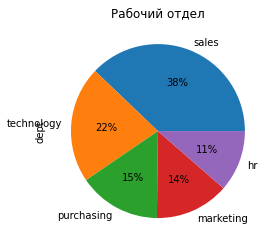

In [23]:
train_job_satisfaction_rate['dept'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Рабочий отдел')
plt.show()

38% сотрудников работают в отделе продаж, 22% - в технологическом отделе, 15% - в отделе закупок, 14% - в маркетинговом отделе, 11% - в HR-отделе. 

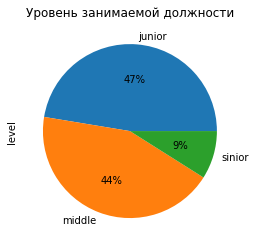

In [24]:
train_job_satisfaction_rate['level'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Уровень занимаемой должности')
plt.show()

47% сотрудников занимают должности уровня junior, 44% - уровня middle, 9% - уровня sinior.

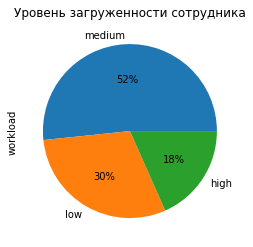

In [25]:
train_job_satisfaction_rate['workload'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Уровень загруженности сотрудника')
plt.show()

У 52% сотрудников уровень загруженности средний (medium), у 30% - низкий (low), у 18% - высокий (high). 

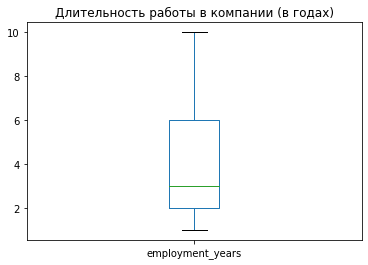

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

In [26]:
train_job_satisfaction_rate['employment_years'].plot.box()
plt.title('Длительность работы в компании (в годах)')
plt.show()
train_job_satisfaction_rate['employment_years'].describe()

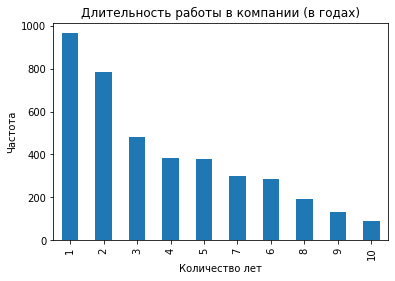

In [27]:
train_job_satisfaction_rate['employment_years'].value_counts().plot(kind='bar')
plt.title('Длительность работы в компании (в годах)')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.show()

Длительность работы сотрудников в компании находится в интервале 1-10 лет, причём среднее значение длительности - 3.72 года; также с увеличением длительности прослеживается уменьшение количества сотрудников.

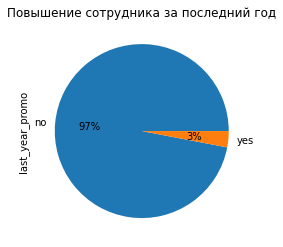

In [28]:
train_job_satisfaction_rate['last_year_promo'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Повышение сотрудника за последний год')
plt.show()

Только 3% сотрудников повысили в должности за последний год. 

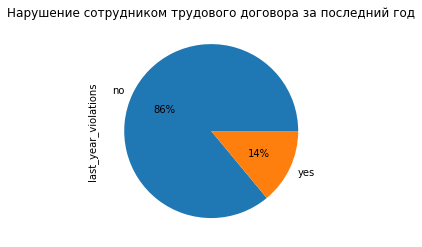

In [29]:
train_job_satisfaction_rate['last_year_violations'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Нарушение сотрудником трудового договора за последний год')
plt.show()

Большинство сотрудников (86%) не нарушали трудовой договор за последний год. 

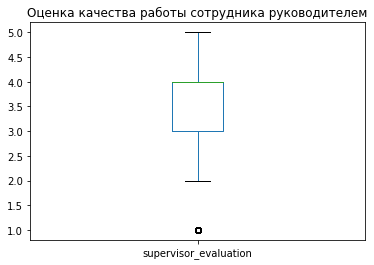

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

In [30]:
train_job_satisfaction_rate['supervisor_evaluation'].plot.box()
plt.title('Оценка качества работы сотрудника руководителем')
plt.show()
train_job_satisfaction_rate['supervisor_evaluation'].describe()

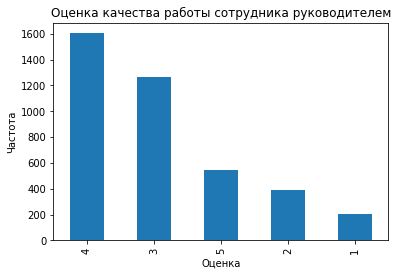

In [31]:
train_job_satisfaction_rate['supervisor_evaluation'].value_counts().plot(kind='bar')
plt.title('Оценка качества работы сотрудника руководителем')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()

Оценки качества работы сотрудника руководителем измеряются по 5-балльной шкале. Больше всего работников имеют оценку 4 (около 1600 человек), более 1200 человек - оценку 3, почти 600 человек - оценку 5, около 400 человек - оценку 2 и более 200 человек - оценку 1. Среднее значение оценки качества - 3.48. 

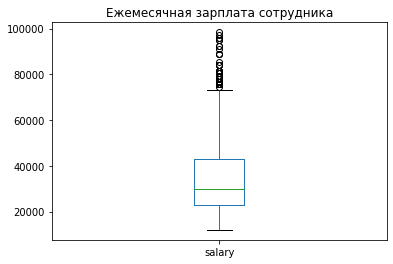

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

In [32]:
train_job_satisfaction_rate['salary'].plot.box()
plt.title('Ежемесячная зарплата сотрудника')
plt.show()
train_job_satisfaction_rate['salary'].describe()

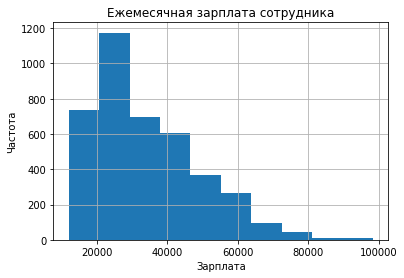

In [33]:
train_job_satisfaction_rate['salary'].hist()
plt.title('Ежемесячная зарплата сотрудника')
plt.xlabel('Зарплата')
plt.ylabel('Частота')
plt.show()

Среднее значение ежемесячной зарплаты сотрудников - почти 34000. Минимальное значение зарплаты - 12000, максимальное - почти 99000. Больше всего сотрудников (почти 1200 человек) имеют зарплату около 20000-30000; чем больше (или меньше) этого значения зарплата, тем меньше человек его (это значение зарплаты) получают. 

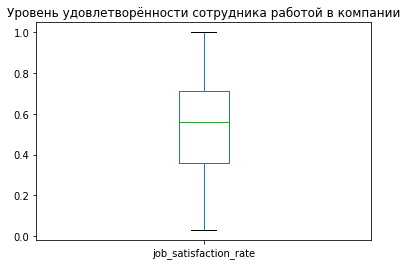

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

In [34]:
train_job_satisfaction_rate['job_satisfaction_rate'].plot.box()
plt.title('Уровень удовлетворённости сотрудника работой в компании')
plt.show()
train_job_satisfaction_rate['job_satisfaction_rate'].describe()

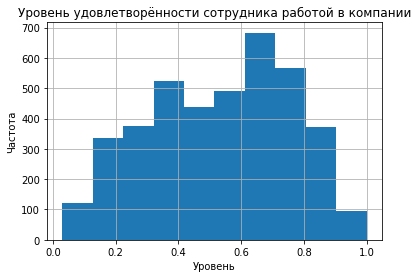

In [35]:
train_job_satisfaction_rate['job_satisfaction_rate'].hist()
plt.title('Уровень удовлетворённости сотрудника работой в компании')
plt.xlabel('Уровень')
plt.ylabel('Частота')
plt.show()

Больше всего сотрудников (почти 700 человек) оценивают удовлетворённость работой в компании в 0.6-0.7, более 550 человек - в 0.7-0.8, более 500 человек - в 0.33-0.4, почти 500 человек - в 0.53-0.6, почти 450 человек - в 0.4-0.53, почти по 400 человек - в 0.23-0.33 и в 0.8-0.9, почти 350 человек - в 0.13-0.23, более 100 человек - в 0.03-0.13 и почти 100 человек - в 0.9-1.0. 

### Входные признаки тестовой выборки

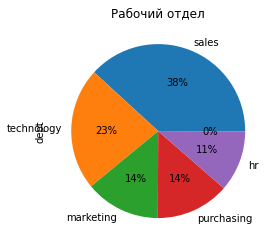

In [36]:
test_features['dept'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Рабочий отдел')
plt.show()

38% сотрудников работают в отделе продаж, 23% - в технологическом отделе, по 14% - в маркетинговом отделе и отделе закупок и 11% - в HR-отделе. 

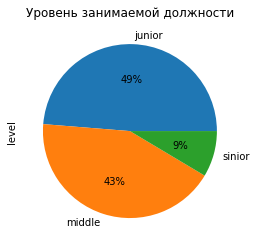

In [37]:
test_features['level'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Уровень занимаемой должности')
plt.show()

49% сотрудников занимают должности уровня junior, 43% - уровня middle, 9% - уровня sinior.

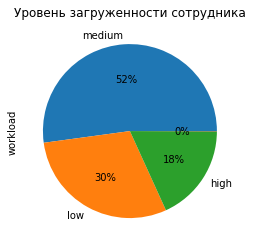

In [38]:
test_features['workload'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Уровень загруженности сотрудника')
plt.show()

У 52% сотрудников уровень загруженности средний (medium), у 30% - низкий (low), у 18% - высокий (high).

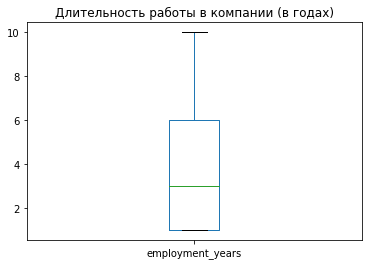

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

In [39]:
test_features['employment_years'].plot.box()
plt.title('Длительность работы в компании (в годах)')
plt.show()
test_features['employment_years'].describe()

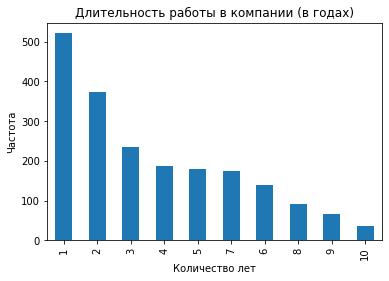

In [40]:
test_features['employment_years'].value_counts().plot(kind='bar')
plt.title('Длительность работы в компании (в годах)')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.show()

Длительность работы сотрудников в компании находится в интервале 1-10 лет, причём среднее значение длительности - 3.67 года; также с увеличением длительности прослеживается уменьшение количества сотрудников.

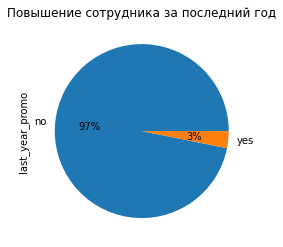

In [41]:
test_features['last_year_promo'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Повышение сотрудника за последний год')
plt.show()

Только 3% сотрудников повысили в должности за последний год.

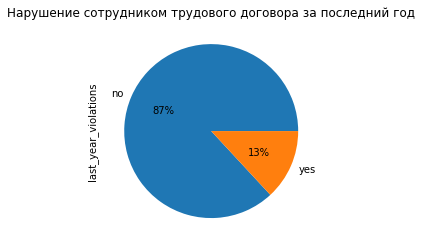

In [42]:
test_features['last_year_violations'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Нарушение сотрудником трудового договора за последний год')
plt.show()

Большинство сотрудников (87%) не нарушали трудовой договор за последний год.

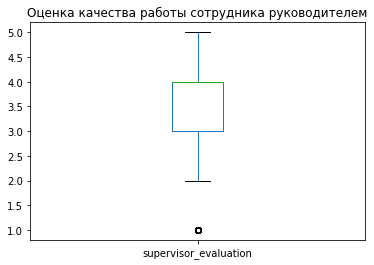

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

In [43]:
test_features['supervisor_evaluation'].plot.box()
plt.title('Оценка качества работы сотрудника руководителем')
plt.show()
test_features['supervisor_evaluation'].describe()

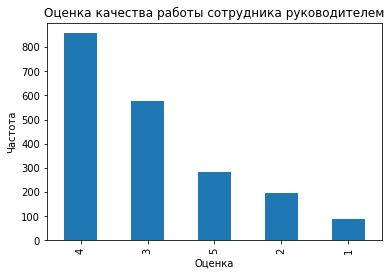

In [44]:
test_features['supervisor_evaluation'].value_counts().plot(kind='bar')
plt.title('Оценка качества работы сотрудника руководителем')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()

Оценки качества работы сотрудника руководителем измеряются по 5-балльной шкале. Больше всего работников имеют оценку 4 (около 850 человек), почти 600 человек - оценку 3, почти 300 человек - оценку 5, около 200 человек - оценку 2 и почти 100 человек - оценку 1. Среднее значение оценки качества - 3.53.

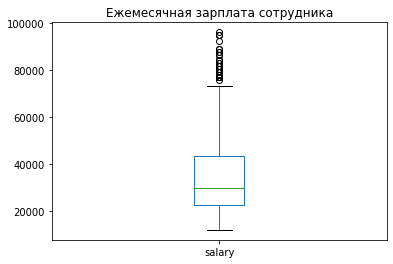

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

In [45]:
test_features['salary'].plot.box()
plt.title('Ежемесячная зарплата сотрудника')
plt.show()
test_features['salary'].describe()

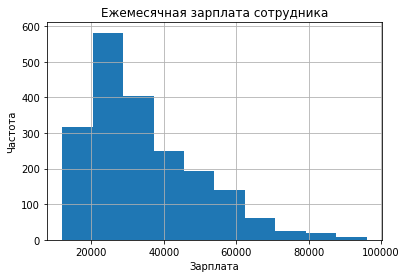

In [46]:
test_features['salary'].hist()
plt.title('Ежемесячная зарплата сотрудника')
plt.xlabel('Зарплата')
plt.ylabel('Частота')
plt.show()

Среднее значение ежемесячной зарплаты сотрудников - около 34000. Минимальное значение зарплаты - 12000, максимальное - 96000. Больше всего сотрудников (почти 600 человек) имеют зарплату около 20000-30000; чем больше (или меньше) этого значения зарплата, тем меньше человек его (это значение зарплаты) получают.

### Целевой признак тестовой выборки

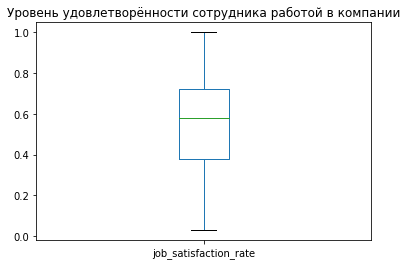

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

In [47]:
test_target_job_satisfaction_rate['job_satisfaction_rate'].plot.box()
plt.title('Уровень удовлетворённости сотрудника работой в компании')
plt.show()
test_target_job_satisfaction_rate['job_satisfaction_rate'].describe()

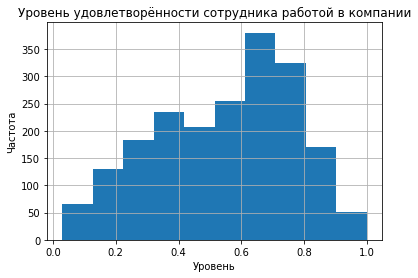

In [48]:
test_target_job_satisfaction_rate['job_satisfaction_rate'].hist()
plt.title('Уровень удовлетворённости сотрудника работой в компании')
plt.xlabel('Уровень')
plt.ylabel('Частота')
plt.show()

Больше всего сотрудников (около 375 человек) оценивают удовлетворённость работой в компании в 0.6-0.7, около 325 человек - в 0.7-0.8, более 250 человек - в 0.52-0.6, почти 250 человек - в 0.33-0.4, более 200 человек - в 0.4-0.52, почти 200 человек - в 0.21-0.33, около 175 человек - в 0.8-0.9, около 130 человек - в 0.13-0.21, около 60 человек - в 0.03-0.13 и более 50 человек - в 0.9-1.0.

### Корреляционный анализ

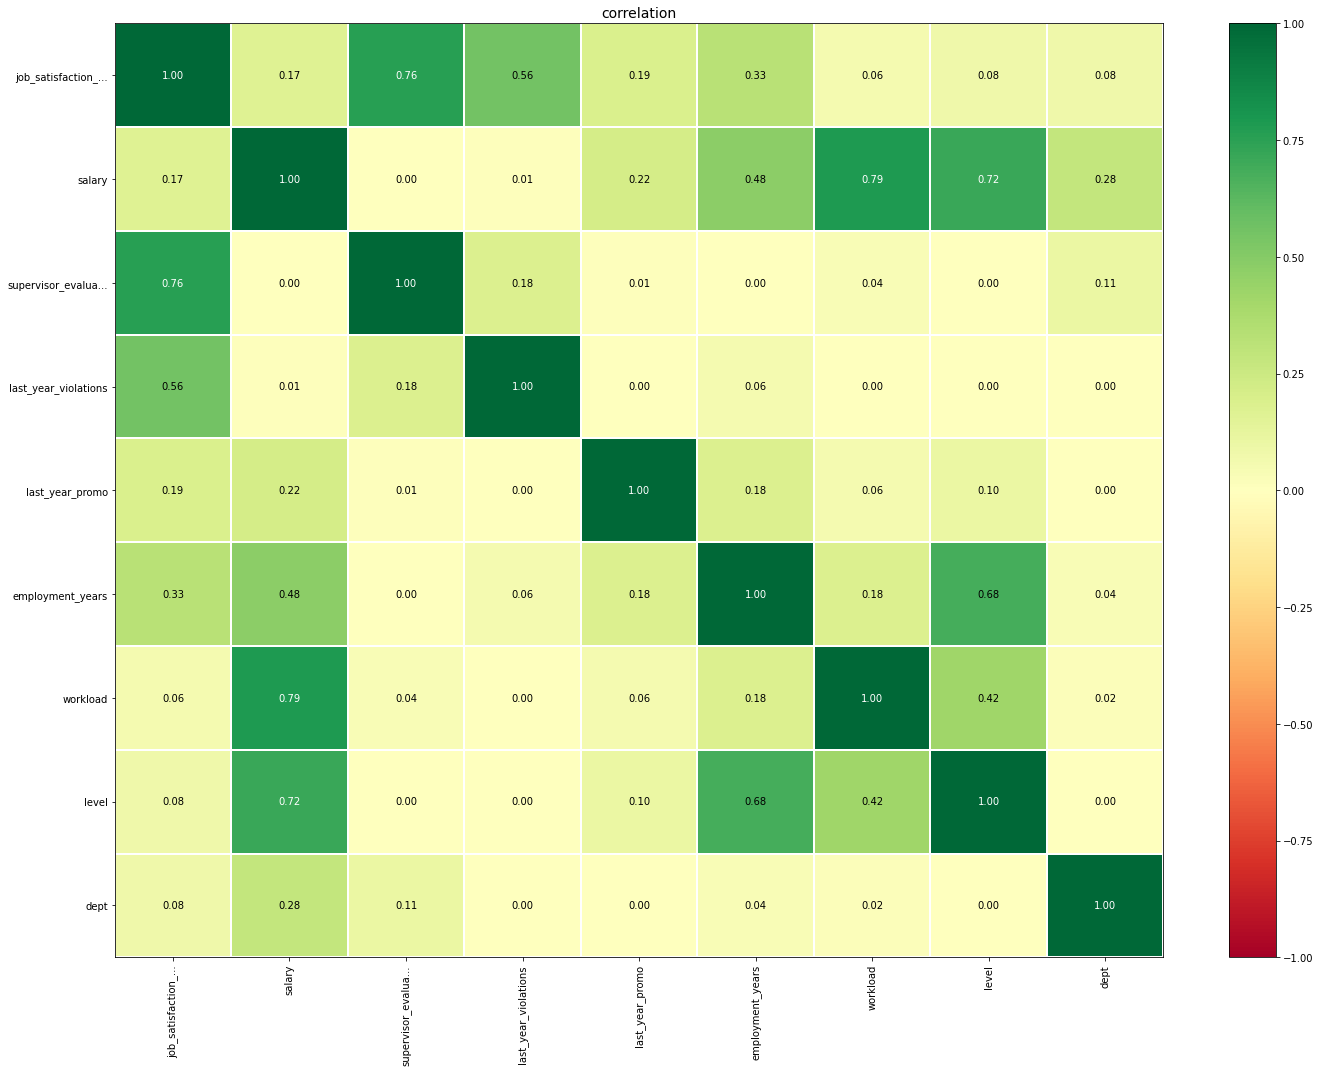

In [49]:
interval_cols = ['employment_years', 'salary', 'job_satisfaction_rate']
corr_matrix_1 = train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    corr_matrix_1.values,
    x_labels=corr_matrix_1.columns,
    y_labels=corr_matrix_1.index,
    figsize=(20,15)
)

По построенной матрице корреляции можно сделать следующие выводы:
- Мультиколлинеарность не прослеживается;
- Связь отсутствует между признаками:
  - 'salary' и 'supervisor_evaluation';
  - 'employment_years' и 'supervisor_evaluation';
  - 'level' и 'supervisor_evaluation';
  - 'last_year_promo' и 'last_year_violations';
  - 'workload' и 'last_year_violations';
  - 'level' и 'last_year_violations';
  - 'dept' и 'last_year_violations';
  - 'last_year_promo' и 'dept';
  - 'level' и 'dept';
- Связь практически отсутствует между признаками:
  - 'job_satisfaction_rate' и 'workload';
  - 'job_satisfaction_rate' и 'level';
  - 'job_satisfaction_rate' и 'dept';
  - 'salary' и 'last_year_violations';
  - 'supervisor_evaluation' и 'last_year_promo';
  - 'supervisor_evaluation' и 'workload';
  - 'last_year_violations' и 'employment_years';
  - 'last_year_promo' и 'workload';
  - 'employment_years' и 'dept';
  - 'workload' и 'dept';
- Слабая связь наблюдается между признаками:
  - 'job_satisfaction_rate' и 'salary';
  - 'job_satisfaction_rate' и 'last_year_promo';
  - 'salary' и 'last_year_promo';
  - 'salary' и 'dept';
  - 'supervisor_evaluation' и 'last_year_violations';
  - 'supervisor_evaluation' и 'dept';
  - 'last_year_promo' и 'employment_years';
  - 'last_year_promo' и 'level';
  - 'employment_years' и 'workload';
- Умеренная связь наблюдается между признаками:
  - 'job_satisfaction_rate' и 'employment_years';
  - 'salary' и 'employment_years';
  - 'workload' и 'level';
- Заметная связь наблюдается между признаками:
  - 'job_satisfaction_rate' и 'last_year_violations';
  - 'employment_years' и 'level';
- Высокая связь наблюдается между признаками:
  - 'job_satisfaction_rate' и 'supervisor_evaluation';
  - 'salary' и 'workload';
  - 'salary' и 'level'.

### Промежуточный вывод

На данном этапе был проведён исследовательский анализ данных: для каждого признака 3-х датасетов были построены и проанализированы графики, а также были посчитаны и проанализированы коэффициенты корреляции для различных признаков.

## Подготовка данных

In [50]:
#объединение входных признаков и целевого признака тестовой выборки
test_job_satisfaction_rate = pd.merge(test_features, test_target_job_satisfaction_rate, on='id')

In [51]:
test_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [52]:
X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate', 'id'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
X_test = test_job_satisfaction_rate.drop(['job_satisfaction_rate', 'id'], axis=1)
y_test = test_job_satisfaction_rate['job_satisfaction_rate']

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload', 'supervisor_evaluation']
num_columns = ['employment_years', 'salary']

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], ['low', 'medium', 'high'], [1, 2, 3, 4, 5],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ]
)

ohe_pipe = Pipeline([
    #('replace_missing', SimpleImputer(missing_values=np.nan, strategy='most_frequent', fill_value=np.nan)),
     #('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
])

num_pipe = Pipeline(
    [('standard', StandardScaler()),
     ('minmax', MinMaxScaler()),
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 8), (2000, 8), (4000,), (2000,))

### Промежуточный вывод

На данном этапе были объединены данные тестовой выборки (т.к. индексы в датасетах с входными признаками и целевым признаком могут не совпасть) и подготовлены признаки в пайплайне для обучения моделей. 

## Обучение моделей

In [54]:
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape_scorer = make_scorer(smape, greater_is_better=False)

In [55]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,15),
        'models__max_features': range(1, len(X_train.columns) + 1),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    scoring=smape_scorer,
    error_score='raise',
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               ('simpleImputer_after_ord',
                                                                                                SimpleImputer(...
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(1, 15),
                                         'models__max_features': range(1, 9),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [56]:
result = pd.DataFrame(randomized_search.cv_results_)
print(display(result))
print(display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')))
pd.set_option('display.max_colwidth', None)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.029725,0.001719,0.010978,0.000546,StandardScaler(),3,1,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-38.715959,-40.517972,-40.177226,-38.968189,-38.400970,-39.356063,0.836268,9
1,0.031696,0.001953,0.011655,0.000811,StandardScaler(),6,8,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-17.503890,-18.115773,-17.413739,-18.628914,-17.258928,-17.784249,0.512876,3
2,0.034883,0.004512,0.012270,0.002038,MinMaxScaler(),8,9,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-16.850044,-16.137337,-17.143362,-17.334009,-16.135634,-16.720077,0.500826,1
3,0.032647,0.004397,0.010787,0.000233,MinMaxScaler(),8,7,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-18.266587,-18.036608,-18.627627,-18.173264,-17.611787,-18.143174,0.330018,4
4,0.035675,0.004948,0.013255,0.002060,MinMaxScaler(),7,4,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-21.990492,-22.095346,-22.518868,-21.166893,-20.710624,-21.696445,0.659429,7
5,0.027651,0.001062,0.009963,0.000493,passthrough,1,13,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-20.731414,-20.665290,-17.814330,-18.944813,-17.745690,-19.180307,1.310770,6
6,0.027005,0.001317,0.010349,0.000207,MinMaxScaler(),3,1,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-38.715959,-40.517972,-40.177226,-38.968189,-38.400970,-39.356063,0.836268,9
7,0.030007,0.001515,0.010679,0.000261,StandardScaler(),4,10,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-17.865613,-18.996571,-17.590856,-17.917082,-18.883001,-18.250625,0.574650,5
8,0.028082,0.000421,0.010606,0.000271,StandardScaler(),1,4,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-37.256626,-38.913740,-38.989949,-29.267418,-28.411191,-34.567785,4.725892,8
9,0.027881,0.000715,0.010141,0.000642,passthrough,6,9,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-17.013809,-16.756515,-16.880436,-16.614267,-16.920434,-16.837092,0.138706,2


None


,rank_test_score,param_models,mean_test_score,params
2,1,DecisionTreeRegressor(random_state=42),-16.720077,"{'preprocessor__num': MinMaxScaler(), 'models_..."
9,2,DecisionTreeRegressor(random_state=42),-16.837092,"{'preprocessor__num': 'passthrough', 'models__..."
1,3,DecisionTreeRegressor(random_state=42),-17.784249,"{'preprocessor__num': StandardScaler(), 'model..."
3,4,DecisionTreeRegressor(random_state=42),-18.143174,"{'preprocessor__num': MinMaxScaler(), 'models_..."
7,5,DecisionTreeRegressor(random_state=42),-18.250625,"{'preprocessor__num': StandardScaler(), 'model..."
5,6,DecisionTreeRegressor(random_state=42),-19.180307,"{'preprocessor__num': 'passthrough', 'models__..."
4,7,DecisionTreeRegressor(random_state=42),-21.696445,"{'preprocessor__num': MinMaxScaler(), 'models_..."
8,8,DecisionTreeRegressor(random_state=42),-34.567785,"{'preprocessor__num': StandardScaler(), 'model..."
0,9,DecisionTreeRegressor(random_state=42),-39.356063,"{'preprocessor__num': StandardScaler(), 'model..."
6,9,DecisionTreeRegressor(random_state=42),-39.356063,"{'preprocessor__num': MinMaxScaler(), 'models_..."


None


In [57]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

y_test_pred = randomized_search.predict(X_test)
print(f'Метрика smape на тестовой выборке: {smape(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [58]:
print(randomized_search.best_params_)

{'preprocessor__num': MinMaxScaler(), 'models__max_features': 8, 'models__max_depth': 9, 'models': DecisionTreeRegressor(random_state=42)}


### Промежуточный вывод

На данном этапе были обучены 2 модели: линейная регрессия и дерево решений. Качество моделей оценивалось с помощью новой метрики smape (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 

Лучше всего справился DecisionTreeRegressor с масштабированием MinMaxScaler() и с гиперпараметрами models__max_features=8, models__max_depth=12.

# Шаг 2 - предсказание увольнения сотрудника из компании

## Загрузка данных

### Тренировочная выборка

In [59]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [60]:
train_quit.info()
train_quit.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


(4000, 10)

### Входные признаки тестовой выборки

Входные признаки тестовой выборки те же, что и для прошлого шага (датасет test_features).

### Целевой признак тестовой выборки

In [61]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [62]:
test_target_quit.info()
test_target_quit.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


(2000, 2)

### Промежуточный вывод

На данном шаге используются те же входные признаки, что и для предыдущего шага, однако изменился целевой признак: это *quit* - увольнение сотрудника из компании.

## Предобработка данных

### Поиск пропусков

Исходя из первого пункта работы (результат работы метода info(), видим, что пропусков нет. 

### Обработка дубликатов

#### Тренировочная выборка

In [63]:
train_quit.duplicated().sum()

0

In [64]:
train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [65]:
train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [66]:
train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [67]:
train_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [68]:
train_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [69]:
train_quit['quit'].unique()

array(['no', 'yes'], dtype=object)

#### Входные признаки тестовой выборки

Дубликаты были изучены на предыдущем шаге (на данном шаге используются те же данные). 

#### Целевой признак тестовой выборки

In [70]:
test_target_quit.duplicated().sum()

0

In [71]:
test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

### Проверка на корректность типов данных столбцов датасетов и самих данных 

In [72]:
b = ['id', 'employment_years', 'supervisor_evaluation', 'salary']

#Тренировочная выборка
for i in b:
    train_quit[i] = train_quit[i].astype(np.int32)
#Целевой признак тестовой выборки
test_target_quit['id'] = test_target_quit['id'].astype(np.int32)

### Промежуточный вывод

На данном этапе была проведена предобработка данных: выявлено отсутствие пропусков и дубликатов и преобразованы типы данных для некоторых столбцов для удобства в дальнейшей работе.

## Исследовательский анализ данных

### Тренировочная выборка

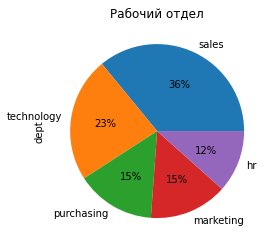

In [73]:
train_quit['dept'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Рабочий отдел')
plt.show()

36% сотрудников работают в отделе продаж, 23% - в технологическом отделе, по 15% - в отделе закупок и в маркетинговом отделе, 12% - в HR-отделе.

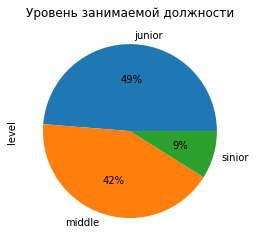

In [74]:
train_quit['level'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Уровень занимаемой должности')
plt.show()

49% сотрудников занимают должности уровня junior, 42% - уровня middle, 9% - уровня sinior.

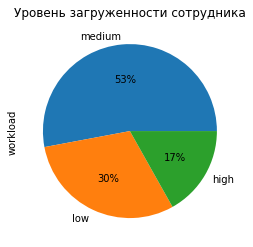

In [75]:
train_quit['workload'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Уровень загруженности сотрудника')
plt.show()

У 53% сотрудников уровень загруженности средний (medium), у 30% - низкий (low), у 17% - высокий (high).

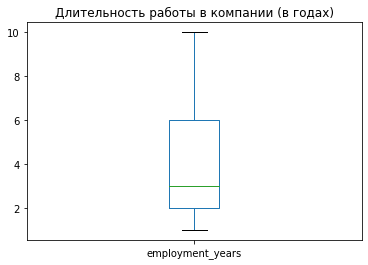

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

In [76]:
train_quit['employment_years'].plot.box()
plt.title('Длительность работы в компании (в годах)')
plt.show()
train_quit['employment_years'].describe()

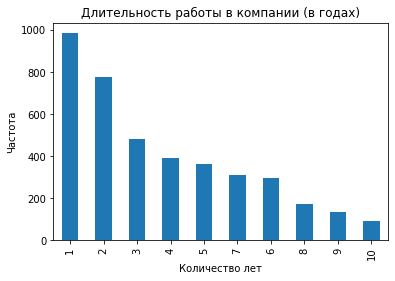

In [77]:
train_quit['employment_years'].value_counts().plot(kind='bar')
plt.title('Длительность работы в компании (в годах)')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.show()

Длительность работы сотрудников в компании находится в интервале 1-10 лет, причём среднее значение длительности - 3.7 лет; также с увеличением длительности прослеживается уменьшение количества сотрудников.

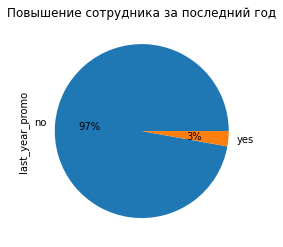

In [78]:
train_quit['last_year_promo'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Повышение сотрудника за последний год')
plt.show()

Только 3% сотрудников повысили в должности за последний год.

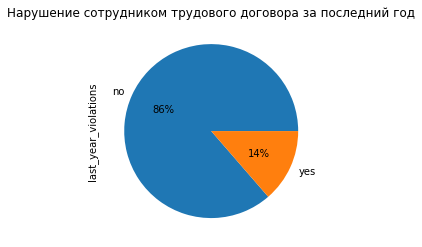

In [79]:
train_quit['last_year_violations'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Нарушение сотрудником трудового договора за последний год')
plt.show()

Большинство сотрудников (86%) не нарушали трудовой договор за последний год.

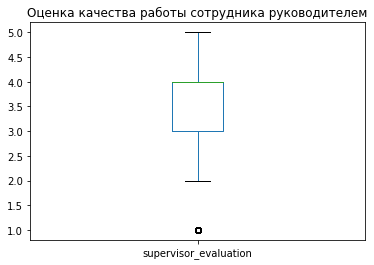

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

In [80]:
train_quit['supervisor_evaluation'].plot.box()
plt.title('Оценка качества работы сотрудника руководителем')
plt.show()
train_quit['supervisor_evaluation'].describe()

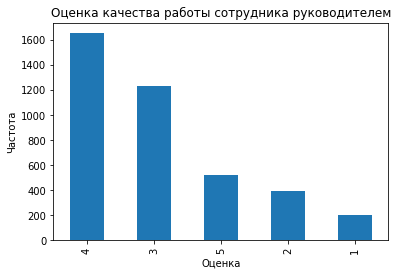

In [81]:
train_quit['supervisor_evaluation'].value_counts().plot(kind='bar')
plt.title('Оценка качества работы сотрудника руководителем')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()

Оценки качества работы сотрудника руководителем измеряются по 5-балльной шкале. Больше всего работников имеют оценку 4 (более 1600 человек), более 1200 человек - оценку 3, почти 600 человек - оценку 5, около 400 человек - оценку 2 и около 200 человек - оценку 1. Среднее значение оценки качества - 3.47.

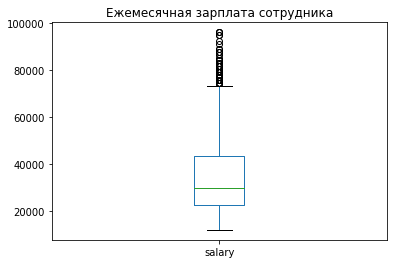

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

In [82]:
train_quit['salary'].plot.box()
plt.title('Ежемесячная зарплата сотрудника')
plt.show()
train_quit['salary'].describe()

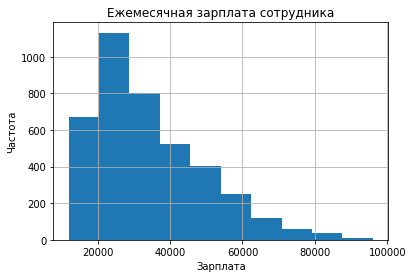

In [83]:
train_quit['salary'].hist()
plt.title('Ежемесячная зарплата сотрудника')
plt.xlabel('Зарплата')
plt.ylabel('Частота')
plt.show()

Среднее значение ежемесячной зарплаты сотрудников - почти 34000. Минимальное значение зарплаты - 12000, максимальное - 96000. Больше всего сотрудников (около 1100 человек) имеют зарплату около 20000-30000; чем больше (или меньше) этого значения зарплата, тем меньше человек его (это значение зарплаты) получают.

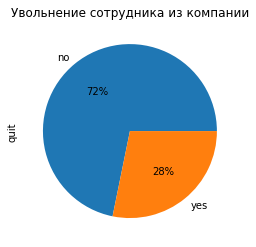

In [84]:
train_quit['quit'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Увольнение сотрудника из компании')
plt.show()

72% сотрудников не уволились, 28% - уволились. 

### Входные признаки тестовой выборки

EDA для данного датасета был проведё на предыдущем шаге. 

### Целевой признак тестовой выборки

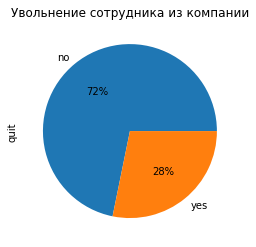

In [85]:
test_target_quit['quit'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Увольнение сотрудника из компании')
plt.show()

72% сотрудников не уволились, 28% - уволились.

### Корреляционный анализ

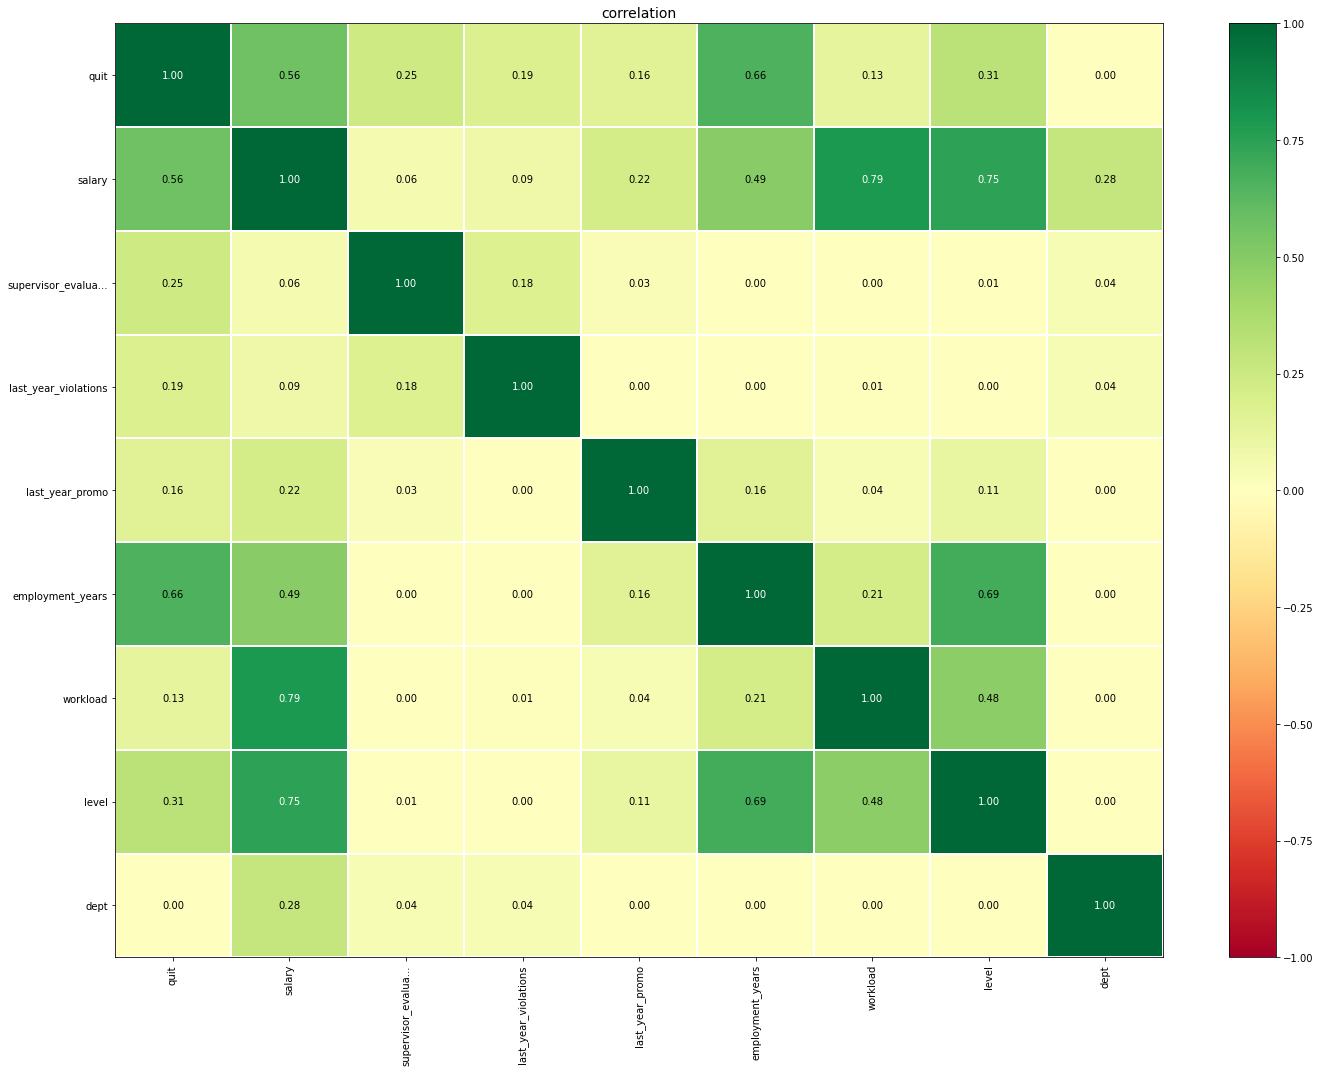

In [86]:
interval_cols = ['employment_years', 'salary', 'job_satisfaction_rate']
corr_matrix_2 = train_quit.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    corr_matrix_2.values,
    x_labels=corr_matrix_2.columns,
    y_labels=corr_matrix_2.index,
    figsize=(20,15)
)

По построенной матрице корреляции можно сделать следующие выводы:
- Мультиколлинеарность не прослеживается;
- Связь отсутствует между признаками:
  - 'quit' и 'dept';
  - 'supervisor_evaluation' и 'employment_years';
  - 'supervisor_evaluation' и 'workload';
  - 'last_year_violations' и 'last_year_promo';
  - 'last_year_violations' и 'employment_years';
  - 'last_year_violations' и 'level';
  - 'last_year_promo' и 'dept';
  - 'employment_years' и 'dept';
  - 'workload' и 'dept';
  - 'level' и 'dept';
- Связь практически отсутствует между признаками:
  - 'salary' и 'supervisor_evaluation';
  - 'salary' и 'last_year_violations';
  - 'supervisor_evaluation' и 'last_year_promo';
  - 'supervisor_evaluation' и 'level';
  - 'supervisor_evaluation' и 'dept';
  - 'last_year_violations' и 'workload';
  - 'last_year_violations' и 'dept';
  - 'last_year_promo' и 'workload';
- Слабая связь наблюдается между признаками:
  - 'quit' и 'supervisor_evaluation';
  - 'quit' и 'last_year_violations';
  - 'quit' и 'last_year_promo';
  - 'quit' и 'workload';
  - 'salary' и 'last_year_promo';
  - 'salary' и 'dept';
  - 'supervisor_evaluation' и 'last_year_violations';
  - 'last_year_promo' и 'employment_years';
  - 'last_year_promo' и 'level';
  - 'employment_years' и 'workload';
- Умеренная связь наблюдается между признаками:
  - 'quit' и 'level';
  - 'salary' и 'employment_years';
  - 'workload' и 'level';
- Заметная связь наблюдается между признаками:
  - 'quit' и 'salary';
  - 'quit' и 'employment_years';
  - 'employment_years' и 'level';
- Высокая связь наблюдается между признаками:
  - 'salary' и 'workload';
  - 'salary' и 'level'.

### Портрет «уволившегося сотрудника»

Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

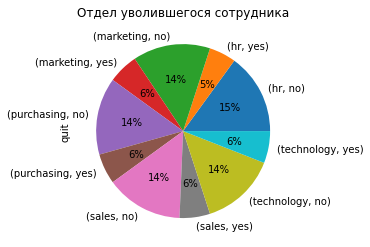

In [87]:
#train_quit.loc[train_quit['quit'] == 'yes', 'dept'].value_counts().plot(kind='pie', autopct='%1.0f%%')

train_quit.groupby(['dept'])['quit'].value_counts(normalize=True).plot(kind='pie', autopct='%1.0f%%')
plt.title('Отдел уволившегося сотрудника')
plt.show()

In [88]:
train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

В разных отделах доля уволившихся сотрудников примерно одинакова (по 5-6% от общего количества всех сотрудников, в том числе и работающих). 

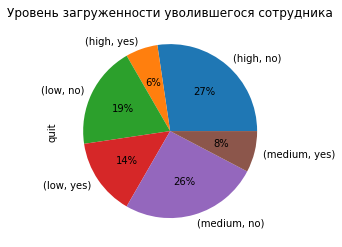

In [89]:
#train_quit.loc[train_quit['quit'] == 'yes', 'workload'].value_counts().plot(kind='pie', autopct='%1.0f%%')

train_quit.groupby(['workload'])['quit'].value_counts(normalize=True).plot(kind='pie', autopct='%1.0f%%')
plt.title('Уровень загруженности уволившегося сотрудника')
plt.show()

Среди всех сотрудников 14% приходится на уволившихся, чья рабочая загруженность была низкой, 8% - на уволившихся со средней загруженностью и 6% уволившихся - с высокой загруженностью. 

In [90]:
print(f"Среднее значение зарплаты сотрудников, оставшихся в компании: {train_quit.loc[train_quit['quit'] == 'no', 'salary'].mean().round(2)}")
print(f"Среднее значение зарплаты ушедших с компании сотрудников: {train_quit.loc[train_quit['quit'] == 'yes', 'salary'].mean().round(2)}")

Среднее значение зарплаты сотрудников, оставшихся в компании: 37702.23
Среднее значение зарплаты ушедших с компании сотрудников: 23885.11


На основе выше построенных диаграмм и сделанных расчётов можно составить приблизительный портрет «уволившегося сотрудника»: это сотрудник с любого отдела с низкой рабочей загруженностью и со средней зарплатой в 23885. 

### Влияние удовлетворённости сотрудника работой в компании на его увольнение

In [91]:
#объединим целевые признаки
relation = pd.merge(test_target_job_satisfaction_rate, test_target_quit, on='id')

In [92]:
print(relation.head())
relation.shape

       id  job_satisfaction_rate quit
0  130604                   0.74   no
1  825977                   0.75   no
2  418490                   0.60  yes
3  555320                   0.72   no
4  826430                   0.08  yes


(2000, 3)

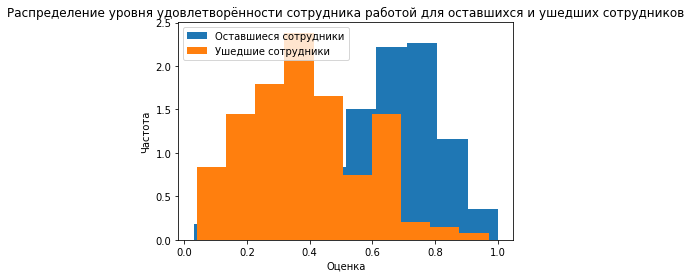

In [93]:
plt.hist(relation.loc[relation['quit'] == 'no', 'job_satisfaction_rate'], label='Оставшиеся сотрудники', density=True)
plt.hist(relation.loc[relation['quit'] == 'yes', 'job_satisfaction_rate'], label='Ушедшие сотрудники', density=True)

plt.legend()
plt.title('Распределение уровня удовлетворённости сотрудника работой для оставшихся и ушедших сотрудников')
plt.ylabel('Частота')
plt.xlabel('Оценка')
plt.show()

Больше всего оставшихся сотрудников оценивают уровень удовлетворённости работой в компании в примерно 0.6-0.8; больше всего ушедших - в 0.3-0.4. 

In [94]:
print(f"Среднее значение уровня удовлетворённости оставшихся сотрудников работой: {relation.loc[relation['quit'] == 'no', 'job_satisfaction_rate'].mean().round(2)}")
print(f"Среднее значение уровня удовлетворённости ушедших сотрудников работой: {relation.loc[relation['quit'] == 'yes', 'job_satisfaction_rate'].mean().round(2)}")

Среднее значение уровня удовлетворённости оставшихся сотрудников работой: 0.6100000143051147
Среднее значение уровня удовлетворённости ушедших сотрудников работой: 0.38999998569488525


Т.к уровень удовлетворённости уволившихся сотрудников достаточно ниже уровня удовлетворённости работающих сотрудников, это подтверждает утверждение о влиянии уровня удовлетворённости на решение сотрудника уволиться.

### Промежуточный вывод

На данном этапе был проведён исследовательский анализ данных: 
- Для каждого признака датасетов были построены и проанализированы графики; 
- Были посчитаны и проанализированы коэффициенты корреляции для различных признаков;
- Составлен портрет «уволившегося сотрудника»;
- Выявлено влияние удовлетворённости сотрудника работой в компании на его увольнение.

## Добавление нового входного признака

In [95]:
#Предсказанные лучшей моделью первого шага значения job_satisfaction_rate 
predicted_job_satisfaction_rate = pd.DataFrame(randomized_search.best_estimator_.predict(X_test))
predicted_job_satisfaction_rate = predicted_job_satisfaction_rate.rename(columns={0: 'predicted_job_satisfaction_rate'})
test_features['predicted_job_satisfaction_rate'] = predicted_job_satisfaction_rate

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [96]:
predicted_job_satisfaction_rate_doubled = pd.concat([predicted_job_satisfaction_rate, predicted_job_satisfaction_rate], ignore_index=True)

In [97]:
#Предсказанные лучшей моделью первого шага значения job_satisfaction_rate 
train_quit['predicted_job_satisfaction_rate'] = predicted_job_satisfaction_rate_doubled

## Подготовка данных

In [98]:
#объединение входных признаков и целевого признака тестовой выборки
test_quit = pd.merge(test_features, test_target_quit, on='id')

In [99]:
X_train_2 = train_quit.drop(['quit', 'id'], axis=1)
y_train_2 = train_quit['quit']
X_test_2 = test_quit.drop(['quit', 'id'], axis=1)
y_test_2 = test_quit['quit']

label_encoder = LabelEncoder()
y_train_2 = label_encoder.fit_transform(y_train_2)
y_test_2 = label_encoder.transform(y_test_2)

ohe_columns_2 = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns_2 = ['level', 'workload', 'supervisor_evaluation']
num_columns_2 = ['employment_years', 'salary', 'predicted_job_satisfaction_rate']

ord_pipe_2 = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], ['low', 'medium', 'high'], [1, 2, 3, 4, 5],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

ohe_pipe_2 = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ])

num_pipe_2 = Pipeline(
    [('standard', StandardScaler()),
     ('minmax', MinMaxScaler())
    ]
    )

data_preprocessor_2 = ColumnTransformer(
    [('ohe', ohe_pipe_2, ohe_columns_2),
     ('ord', ord_pipe_2, ord_columns_2),
     ('num', num_pipe_2, num_columns_2)
    ], 
    remainder='passthrough'
)

In [100]:
X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape

((4000, 9), (2000, 9), (4000,), (2000,))

### Промежуточный вывод

На данном этапе были объединены данные тестовой выборки (т.к. индексы в датасетах с входными признаками и целевым признаком могут не совпасть) и подготовлены признаки в пайплайне для обучения моделей.

## Обучение моделей

In [101]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_2 = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 30),
        'models__max_features': range(1, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC()],
        'models__C': [0.1, 1, 10, 100, 1000],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_2,
    scoring = 'roc_auc', 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)

randomized_search_2.fit(X_train_2, y_train_2) 

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC()],
                                         'models__C': [0.1, 1, 10, 100, 1000],
                                         'models__kernel': ['linear', 'poly',
                                                            'rbf', 'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [102]:
result_2 = pd.DataFrame(randomized_search_2.cv_results_)
print(display(result_2))
print(display(result_2[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.035115,0.006805,0.012943,0.001530,passthrough,26,10,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 26, 'models__max_depth': 10, 'models': DecisionTreeClassifier(random_state=42)}",0.845163,0.900081,0.854865,0.878901,0.907292,0.877260,0.024319,3
1,0.032177,0.001726,0.014169,0.001934,MinMaxScaler(),26,15,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 26, 'models__max_depth': 15, 'models': DecisionTreeClassifier(random_state=42)}",0.815107,0.829434,0.833820,0.852668,0.866174,0.839441,0.017964,7
2,0.032143,0.003537,0.010864,0.000300,passthrough,29,13,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 29, 'models__max_depth': 13, 'models': DecisionTreeClassifier(random_state=42)}",0.810041,0.841279,0.839694,0.861367,0.870691,0.844614,0.020935,5
3,0.036018,0.003243,0.013081,0.000657,StandardScaler(),18,13,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 18, 'models__max_depth': 13, 'models': DecisionTreeClassifier(random_state=42)}",0.810041,0.838941,0.840592,0.861367,0.873131,0.844814,0.021621,4
4,0.040129,0.005973,0.015449,0.001819,StandardScaler(),25,19,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 25, 'models__max_depth': 19, 'models': DecisionTreeClassifier(random_state=42)}",0.808854,0.834504,0.822273,0.841918,0.866409,0.834792,0.019391,8
5,0.036038,0.003387,0.012833,0.000478,StandardScaler(),28,25,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 28, 'models__max_depth': 25, 'models': DecisionTreeClassifier(random_state=42)}",0.804352,0.834504,0.821398,0.836148,0.861402,0.831561,0.018782,9
6,0.031701,0.002965,0.012660,0.001141,MinMaxScaler(),11,6,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 11, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}",0.915467,0.928390,0.904104,0.907546,0.934692,0.918040,0.011793,1
7,0.030150,0.002337,0.012071,0.001148,passthrough,7,15,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 7, 'models__max_depth': 15, 'models': DecisionTreeClassifier(random_state=42)}",0.826199,0.842609,0.849615,0.850109,0.849997,0.843706,0.009200,6
8,0.033011,0.005095,0.011731,0.000393,StandardScaler(),24,4,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 24, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}",0.912012,0.907285,0.912167,0.919313,0.926294,0.915414,0.006660,2
9,0.029801,0.001212,0.013143,0.001340,StandardScaler(),2,18,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 2, 'models__max_depth': 18, 'models': DecisionTreeClassifier(random_state=42)}",0.797979,0.813360,0.822061,0.789823,0.806242,0.805893,0.011297,10


None


,rank_test_score,param_models,mean_test_score,params
6,1,DecisionTreeClassifier(random_state=42),0.918040,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 11, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
8,2,DecisionTreeClassifier(random_state=42),0.915414,"{'preprocessor__num': StandardScaler(), 'models__max_features': 24, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
0,3,DecisionTreeClassifier(random_state=42),0.877260,"{'preprocessor__num': 'passthrough', 'models__max_features': 26, 'models__max_depth': 10, 'models': DecisionTreeClassifier(random_state=42)}"
3,4,DecisionTreeClassifier(random_state=42),0.844814,"{'preprocessor__num': StandardScaler(), 'models__max_features': 18, 'models__max_depth': 13, 'models': DecisionTreeClassifier(random_state=42)}"
2,5,DecisionTreeClassifier(random_state=42),0.844614,"{'preprocessor__num': 'passthrough', 'models__max_features': 29, 'models__max_depth': 13, 'models': DecisionTreeClassifier(random_state=42)}"
7,6,DecisionTreeClassifier(random_state=42),0.843706,"{'preprocessor__num': 'passthrough', 'models__max_features': 7, 'models__max_depth': 15, 'models': DecisionTreeClassifier(random_state=42)}"
1,7,DecisionTreeClassifier(random_state=42),0.839441,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 26, 'models__max_depth': 15, 'models': DecisionTreeClassifier(random_state=42)}"
4,8,DecisionTreeClassifier(random_state=42),0.834792,"{'preprocessor__num': StandardScaler(), 'models__max_features': 25, 'models__max_depth': 19, 'models': DecisionTreeClassifier(random_state=42)}"
5,9,DecisionTreeClassifier(random_state=42),0.831561,"{'preprocessor__num': StandardScaler(), 'models__max_features': 28, 'models__max_depth': 25, 'models': DecisionTreeClassifier(random_state=42)}"
9,10,DecisionTreeClassifier(random_state=42),0.805893,"{'preprocessor__num': StandardScaler(), 'models__max_features': 2, 'models__max_depth': 18, 'models': DecisionTreeClassifier(random_state=42)}"


None


In [103]:
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_2.best_score_)

#y_test_pred_2 = randomized_search_2.predict(X_test_2)
#print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_2, y_test_pred_2)}')

probabilities = randomized_search_2.predict_proba(X_test_2)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test_2, probabilities_one))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [104]:
print(randomized_search_2.best_params_)

{'preprocessor__num': MinMaxScaler(), 'models__max_features': 11, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}


### Промежуточный вывод

На данном этапе были обучены 4 модели: дерево решений, метод k-ближайших соседей, логистическая регрессия и метод опорных векторов.
Лучше всего справился DecisionTreeClassifier с масштабированием MinMaxScaler() и с гиперпараметрами models__max_features=11, models__max_depth=6.

## Общий вывод

В данном проекте была проведена работа с компанией «Работа с заботой», занимающейся управлением персоналом. 

Были решены 2 задачи, в ходе которых были разработаны модели машинного обучения и выбраны лучшие модели, предсказывающие уровень удовлетворённости сотрудника на основе данных заказчика и увольнение сотрудника из компании. 

Были выполнены:
- Шаг 1 - предсказание уровня удовлетворённости сотрудника:
    - Загрузка данных;
    - Предобработка данных;
    - Исследовательский анализ данных: визуализация каждого признака и корреляционный анализ;
    - Подготовка данных: разработка пайплайна;
    - Обучение моделей;
- Шаг 2 - предсказание увольнения сотрудника из компании:
    - Загрузка данных;
    - Предобработка данных;
    - Исследовательский анализ данных: визуализация каждого признака, корреляционный анализ и построение портрета "уволившегося сотрудника";
    - Добавление нового входного признака;
    - Подготовка данных: разработка пайплайна;
    - Обучение моделей.